# Python for Creating CSV and Preliminary Reporting

In [1]:
import csv
import contextily as cx
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import urllib


#import geopandas as gpd

%matplotlib inline
plt.style.use('ggplot')

from datetime import date
print("Last run: ", date.today())

#gv.extension('bokeh', 'matplotlib')

Last run:  2022-09-17


## Load Data and Write to CSV


In [2]:
with open("roman-amphitheaters.geojson") as f:
    j = json.load(f)

In [3]:
# If there is one, I'd welcome a more pythonic approach. One that 
# accomodates the variable data model supported by JSON.

d = []
for feature in j['features']:
    
    # Check for optional properties

    if 'latintoponym' in feature['properties'].keys():
        latintoponym = feature['properties']['latintoponym']
    else:
        latintoponym = ''    

    if 'welchid' in feature['properties'].keys():
        welchid = feature['properties']['welchid']
    else:
        welchid = ''

    if 'golvinid' in feature['properties'].keys():
        golvinid = feature['properties']['golvinid']
    else:
        golvinid = ''

    if 'buildingtype' in feature['properties'].keys():
        buildingtype = feature['properties']['buildingtype']
    else:
        buildingtype = ''
        
    try:
        zotero = feature['properties']['bibliography'][0]['zoteroitem']
    except:
        zotero = ''
 
    if 'chronogroup' in feature['properties'].keys():
        chronogroup = feature['properties']['chronogroup']
    else:
        chronogroup = ''

    secondcentury = True
    if 'exclude' in feature['properties'].keys():
        secondcentury = False

    if 'capacity' in feature['properties'].keys():
        capacity = feature['properties']['capacity']['quantity']
    else:
        capacity = ''

    if 'province' in feature['properties'].keys():
        romanregion = feature['properties']['province']
    elif 'region' in feature['properties'].keys():
        romanregion = feature['properties']['region']
    else:
        romanregion = ''
        
    arenamajor = ''
    arenaminor = ''
    extmajor = ''
    extminor = ''
    exteriorheight = ''
    dimensionsunknown = False
    if 'dimensions' in feature['properties'].keys():
        dimensions = feature['properties']['dimensions']
        
        if 'arenamajor' in dimensions:
            arenamajor = dimensions['arenamajor']

        if 'arenaminor' in dimensions:
            arenaminor = dimensions['arenaminor']
            
        if 'exteriormajor' in dimensions:
            extmajor = dimensions['exteriormajor']

        if 'exteriorminor' in dimensions:
            extminor = dimensions['exteriorminor']
            
        if 'exteriorheight' in dimensions:
            exteriorheight = dimensions['exteriorheight']
            
        if 'unknown' in dimensions:
            dimensionsunknown = True
            
    d.append((feature['id'],
              feature['properties']['title'],
              feature['properties']['label'],
              latintoponym,
              feature['properties']['pleiades'],
              welchid,
              golvinid,
              buildingtype,
              chronogroup,
              secondcentury,
              capacity,
              feature['properties']['moderncountry'],
              romanregion,
              zotero,
              dimensionsunknown,
              arenamajor,
              arenaminor,
              extmajor,
              extminor,
              exteriorheight,
              feature['geometry']['coordinates'][0],
              feature['geometry']['coordinates'][1],
              feature['geometry']['coordinates'][2]))

ramphs_df = pd.DataFrame(d, columns=(
 'id',    # short id
 'title', # longer title
 'label', # short label
 'latintoponym', # latin toponym
 'pleiades', # pleiades https uri
 'welchid',  # id in Welch
 'golvinid', # id in Golvin
 'buildingtype',  # usually 'amphitheater'
 'chronogroup',   # label for the chronological group
 'secondcentury', # is this an amphitheater that was in use in 2nd century
 'capacity',    # capacity as integer
 'modcountry',  # modern country
 'romanregion', # province or augustan region of italy
 'zotero',      # zotero item id
 'dimensionsunknown', # if true, that's a direct statement that no dimensions are available
 'arenamajor', # long axis of arena in meters
 'arenaminor', # short axis of arena in meters
 'extmajor',   # long axis of exterior
 'extminor', # short axis of exterior
 'exteriorheight',   # height of exterior wall if known
 'longitude', # longitude
 'latitude', # latitude
 'elevation'  # elevation in meters.
 )) 

ramphs_df[['capacity','elevation','arenamajor','arenaminor',
        'extmajor','extminor','exteriorheight']] = ramphs_df[['capacity','elevation','arenamajor',
        'arenaminor','extmajor','extminor','exteriorheight']].apply(pd.to_numeric)

In [4]:
ramphs_df.to_csv("roman-amphitheaters.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [5]:
#ramphs_df[['id','title','chronogroup','latintoponym','romanregion','modcountry','capacity',
#           'extmajor','extminor','arenamajor','arenaminor','latitude','longitude']].to_csv('tmp.csv', index = False, quoting = csv.QUOTE_NONNUMERIC)

## Basic Mapping

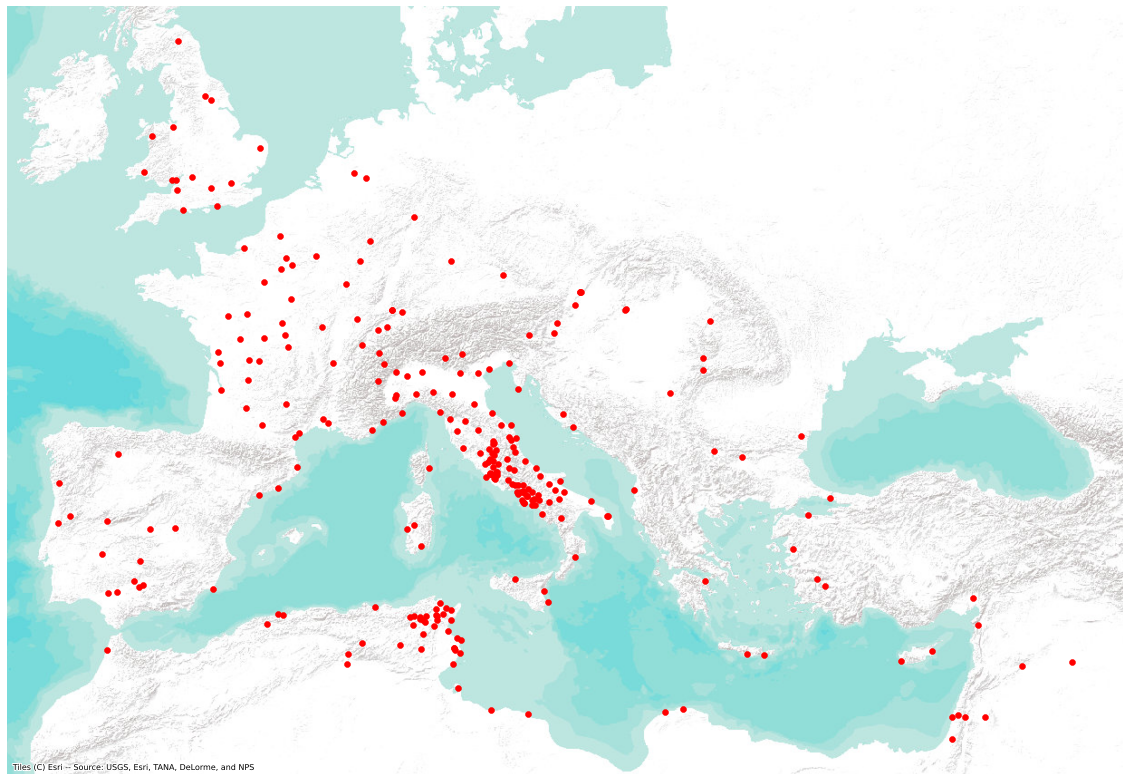

In [6]:
ramphs_gdf = gpd.read_file("roman-amphitheaters.geojson")

ramphs_gdf_epsg3857 = ramphs_gdf.to_crs(3857)

ax = ramphs_gdf_epsg3857.plot(figsize=(20, 20), color = 'red')
cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain)

ax.set_axis_off()
plt.savefig("all-roman-amphitheaters-map.png",pad_inches=0, bbox_inches='tight')

In [7]:
# with roman territory using geopandas


url = "http://sebastianheath.com/roman-maps/roman_empire_ad_200_extent.geojson"
borders_gdf = gpd.read_file(url)

base = borders_gdf.plot(color = 'black', figsize = (40,24))
ramphs_gdf.plot(ax = base, color = 'red', markersize = 100)

plt.grid(False)
plt.axis('off')

plt.savefig('all-roman-amphitheaters-map-dark.png',pad_inches=0, bbox_inches='tight', transparent = True)
plt.close()

## Basic Reporting

In [8]:
ramphs_df.head(2)

,id,title,label,latintoponym,pleiades,welchid,golvinid,buildingtype,chronogroup,secondcentury,...,zotero,dimensionsunknown,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
0,duraEuroposAmphitheater,Amphitheater at Dura Europos,Dura,Dura Europus,https://pleiades.stoa.org/places/893989,,129,amphitheater,severan,False,...,5ADZC245,False,31.0,25.0,50.0,44.0,NaN,40.728926,34.749855,223
1,arlesAmphitheater,Amphitheater at Arles,Arles,Arelate,https://pleiades.stoa.org/places/148217,,154,amphitheater,flavian,True,...,LD7NNHSG,False,47.0,32.0,136.0,107.0,NaN,4.631111,43.677778,21


In [9]:
ramphs_df.describe()

,capacity,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
count,130.000000,171.000000,167.000000,212.000000,191.000000,3.000000,268.000000,268.000000,268.000000
mean,12000.753846,57.018129,38.202994,95.993538,77.258168,41.483333,10.567282,42.245199,196.794776
std,8991.382469,14.502869,8.722000,30.538218,25.401345,9.859048,9.063517,4.941042,211.555393
min,1000.000000,25.000000,19.000000,25.000000,31.000000,32.450000,-8.493330,31.608189,-121.000000
25%,5037.500000,47.000000,32.350000,74.375000,58.900000,36.225000,5.325859,38.480299,34.750000
50%,9700.000000,58.000000,39.000000,94.000000,75.000000,40.000000,10.890095,42.089044,121.000000
75%,16000.000000,66.000000,42.850000,115.000000,95.250000,46.000000,14.184435,45.596976,286.250000
max,50000.000000,104.000000,74.000000,189.000000,156.000000,52.000000,40.728926,55.602600,1170.000000


In [10]:
ramphs_df[ramphs_df.secondcentury].describe()

,capacity,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
count,120.000000,161.000000,157.000000,201.000000,182.000000,2.000000,246.000000,246.000000,246.000000
mean,11700.816667,57.082919,38.340127,95.851393,77.247308,42.225000,10.046911,42.357248,197.150407
std,8852.791643,14.642518,8.813463,29.421104,25.175439,13.823938,8.856168,4.991714,211.790862
min,1200.000000,25.000000,19.000000,25.000000,31.000000,32.450000,-8.493330,31.608189,1.000000
25%,5000.000000,47.000000,32.700000,75.000000,59.100000,37.337500,4.091795,38.686097,35.750000
50%,9000.000000,58.000000,39.000000,94.000000,75.000000,42.225000,10.572890,42.270997,123.500000
75%,15206.500000,67.000000,43.000000,114.000000,94.375000,47.112500,14.053709,45.744273,284.500000
max,50000.000000,104.000000,74.000000,189.000000,156.000000,52.000000,38.273763,55.602600,1170.000000


In [11]:
# Confirm that CSV is readable
# It would be nice if the "numeric pattern" string survived as strings.
pd.read_csv("roman-amphitheaters.csv", quoting = 2).describe()

,welchid,golvinid,capacity,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
count,18.000000,96.000000,130.000000,171.000000,167.000000,212.000000,191.000000,3.000000,268.000000,268.000000,268.000000
mean,9.777778,108.041667,12000.753846,57.018129,38.202994,95.993538,77.258168,41.483333,10.567282,42.245199,196.794776
std,5.704029,61.381279,8991.382469,14.502869,8.722000,30.538218,25.401345,9.859048,9.063517,4.941042,211.555393
min,1.000000,11.000000,1000.000000,25.000000,19.000000,25.000000,31.000000,32.450000,-8.493330,31.608189,-121.000000
25%,5.250000,63.500000,5037.500000,47.000000,32.350000,74.375000,58.900000,36.225000,5.325859,38.480299,34.750000
50%,9.500000,104.500000,9700.000000,58.000000,39.000000,94.000000,75.000000,40.000000,10.890095,42.089044,121.000000
75%,14.500000,143.750000,16000.000000,66.000000,42.850000,115.000000,95.250000,46.000000,14.184435,45.596976,286.250000
max,19.000000,298.000000,50000.000000,104.000000,74.000000,189.000000,156.000000,52.000000,40.728926,55.602600,1170.000000


In [12]:
# which have heights
ramphs_df[ramphs_df.exteriorheight > 0]

,id,title,label,latintoponym,pleiades,welchid,golvinid,buildingtype,chronogroup,secondcentury,...,zotero,dimensionsunknown,arenamajor,arenaminor,extmajor,extminor,exteriorheight,longitude,latitude,elevation
4,romeFlavianAmphitheater,Flavian Amphitheater at Rome,Colosseum,,https://pleiades.stoa.org/places/423025,,152,amphitheater,flavian,True,...,VKMRD8AT,False,83.00,48.00,189.00,156.0,52.00,12.492269,41.890169,22
90,thysdrusAmphitheater,Amphitheater at Thysdrus,Thysdrus (lg.),,https://pleiades.stoa.org/places/324835,,,amphitheater,post-severan,False,...,,False,65.00,39.00,148.00,122.0,40.00,10.706939,35.296390,111
97,pulaAmphitheater,Amphitheater at Pula,Pula,Colonia Pietas Iulia Pola Pollentia Herculanea,https://pleiades.stoa.org/places/197448,,,amphitheater,julio-claudian,True,...,,False,67.95,41.65,132.45,105.1,32.45,13.850243,44.873229,16


In [13]:
# which don't have exteriormajor
ramphs_df[pd.isnull(ramphs_df.extmajor)].sort_values(by = 'longitude')\
[['id','modcountry','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

,id,modcountry,latintoponym,golvinid,extmajor,arenamajor,latitude,longitude
157,bragaAmphitheater,Portugal,Bracara Augusta,,NaN,NaN,41.546669,-8.430075
166,bobadelaAmphitheater,Portugal,Elbocoris,,NaN,50.0,40.361088,-7.893572
56,lixusAmphitheater,Morocco,,,NaN,34.0,35.199900,-6.108468
121,caparraAmphitheater,Spain,Municipium Flavium Caparense,,NaN,30.0,40.164159,-6.100049
159,leonAmphitheater,Spain,Legio,,NaN,NaN,42.598889,-5.566944
193,espejoAmphitheater,Spain,Ucubi,11,NaN,35.0,37.683989,-4.554198
158,sisapoAmphitheater,Spain,,,NaN,NaN,38.645833,-4.516667
266,toledoAmphitheater,Spain,Toletum,,NaN,NaN,39.865349,-4.022888
87,cirencesterAmphitheater,United Kingdom,Corinium Dobunnorum,,NaN,46.0,51.711510,-1.972188
68,aldburoughAmphitheater,United Kingdom,Isurium Brigantium,,NaN,NaN,54.088116,-1.379630


In [14]:
ramphs_df[ramphs_df.golvinid == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

,id,latintoponym,golvinid,extmajor,arenamajor,latitude,longitude
2,lyonAmphitheater,Lugdunum,,105.0,67.6,45.770556,4.830556
3,ludusMagnusArena,Ludus Magnus,,NaN,NaN,41.889950,12.494913
6,eleutheropolisAmphitheater,Eleutheropolis,,71.0,47.0,31.608189,34.893845
7,pompeiiAmphitheater,Pompeii,,135.0,66.0,40.751213,14.495262
9,newsteadAmphitheater,Trimontium,,70.0,37.0,55.602600,-2.691900
...,...,...,...,...,...,...,...
260,torreparedonesAmphitheater,Colonia Virtus Iulia,,69.0,NaN,37.752468,-4.380600
261,nazilliAmphitheater,Mastaura,,NaN,NaN,37.955596,28.338099
262,trentoAmphitheater,Tridentum,,NaN,62.0,46.069205,11.125334
266,toledoAmphitheater,Toletum,,NaN,NaN,39.865349,-4.022888


In [15]:
ramphs_df[ramphs_df.latintoponym == '' ][['id','latintoponym','golvinid','extmajor','arenamajor','latitude','longitude']]

,id,latintoponym,golvinid,extmajor,arenamajor,latitude,longitude
4,romeFlavianAmphitheater,,152,189.00,83.00,41.890169,12.492269
5,romeAmphitheatrumCastrense,,189,88.00,NaN,41.887715,12.515144
19,porolissumAmphitheater,,39,84.00,64.00,47.177552,23.154052
28,italicaAmphitheater,,168,160.00,70.00,37.443893,-6.046742
34,viminaciumAmphitheater,,,85.00,NaN,44.737985,21.220083
35,flaviaSolvaAmphitheater,,,97.00,85.00,46.767153,15.565777
38,octodurusForumClaudiiVallensiumAmphitheater,,,118.00,74.00,46.094356,7.073493
39,cyreneAmphitheater,,,NaN,32.70,32.824526,21.850808
44,charterhouseAmphitheater,,,50.00,32.00,51.305437,-2.720301
47,scythopolisNysaAmphitheater,,,NaN,NaN,32.498395,35.501631


## Duplicate Checking

In [16]:
dups = ramphs_df[ramphs_df.label.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [17]:
dups = ramphs_df[ramphs_df.id.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 0

True

In [18]:
dups = ramphs_df[ramphs_df.pleiades.duplicated(keep = False)]\
[['id','pleiades','latintoponym','latitude','longitude']].sort_values('pleiades')

len(dups) == 15

True

In [19]:
dups = ramphs_df[ramphs_df.latintoponym.duplicated(keep = False)]\
[['id','pleiades','latintoponym',
  'latitude','longitude']].sort_values('pleiades')

len(dups.query("latintoponym != ''")) == 11

True

# Chronogrps

In [20]:
c_grps_from_j = j['romanamphitheaterschronogroups']

In [21]:
c_grps_to_csv = [[g['id'],g['startdate'],g['enddate']] for g in c_grps_from_j]

In [22]:
print(f"In c_grps, not in data: {set([i[0] for i in c_grps_to_csv]) - set([i[8] for i in d])}")
print(f"In data, not in c_grps: {set([i[8] for i in d]) - set([i[0] for i in c_grps_to_csv])}")

In c_grps, not in data: set()
In data, not in c_grps: set()


In [23]:
if (set([i[0] for i in c_grps_to_csv]) == set([i[8] for i in d])):
    c_grps_df = pd.DataFrame(c_grps_to_csv, columns = ('id','startdate','enddate'))
    c_grps_df.to_csv("chronogrps.csv", index = False, quoting = csv.QUOTE_NONNUMERIC)

In [24]:
# Provinces (new, incomplete)